Class Distribution:
 Normal           5106
Network Issue      24
Server Issue        5
Name: Target, dtype: int64

--- Classification Report ---
               precision    recall  f1-score   support

Network Issue       0.88      1.00      0.93         7
       Normal       1.00      1.00      1.00      1533
 Server Issue       0.50      1.00      0.67         1

     accuracy                           1.00      1541
    macro avg       0.79      1.00      0.87      1541
 weighted avg       1.00      1.00      1.00      1541



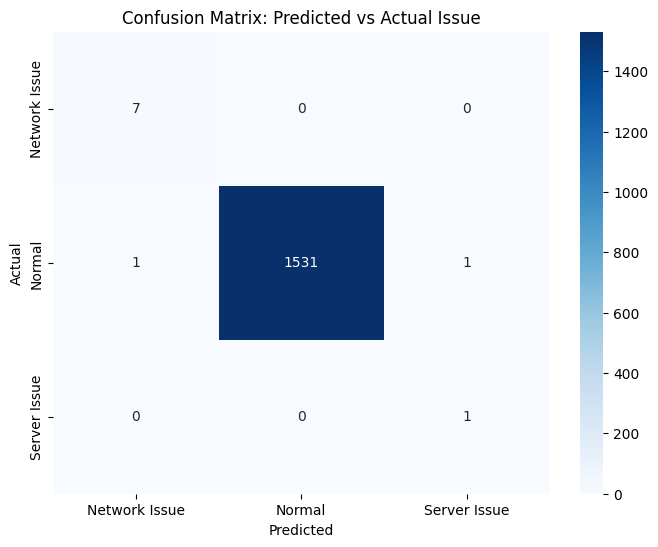

Feature: Time_Delta, Importance: 0.3997
Feature: Length, Importance: 0.1810
Feature: Protocol_Code, Importance: 0.0606
Feature: Info_Length, Importance: 0.3587


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'C:\Users\phani\VScode\Python\Data Science\youtube traffic.csv', encoding='ISO-8859-1')
df['Time_Delta'] = df['Time'].diff().fillna(0)
df['Info_Length'] = df['Info'].apply(str).apply(len)
le_proto = LabelEncoder()
df['Protocol_Code'] = le_proto.fit_transform(df['Protocol'].astype(str))

def define_issue_type(row):
    info = str(row['Info']).lower()
    proto = str(row['Protocol'])
    time_delta = row['Time_Delta']

    if 'retransmission' in info or 'dup ack' in info or 'spurious' in info:
        return 'Network Issue'
    if time_delta > 0.5: 
        return 'Network Issue'
        
    if 'rst' in info or 'window full' in info or 'zerowindow' in info:
        return 'Server Issue'
    
    return 'Normal'

df['Target'] = df.apply(define_issue_type, axis=1)

print("Class Distribution:\n", df['Target'].value_counts())

features = ['Time_Delta', 'Length', 'Protocol_Code', 'Info_Length']
X = df[features]
y = df['Target']

# Split into Training and Testing sets (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Train the Model
# Random Forest is robust and handles mixed data types well
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Evaluate the Model
y_pred = clf.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualize Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix: Predicted vs Actual Issue')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. Feature Importance (What matters most?)
importances = clf.feature_importances_
for name, importance in zip(features, importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Anomalies Detected: 257

--- Supervised Model Performance ---
               precision    recall  f1-score   support

Network Issue       1.00      0.98      0.99       126
       Normal       1.00      1.00      1.00      1414
 Server Issue       0.00      0.00      0.00         1

     accuracy                           1.00      1541
    macro avg       0.67      0.66      0.66      1541
 weighted avg       1.00      1.00      1.00      1541



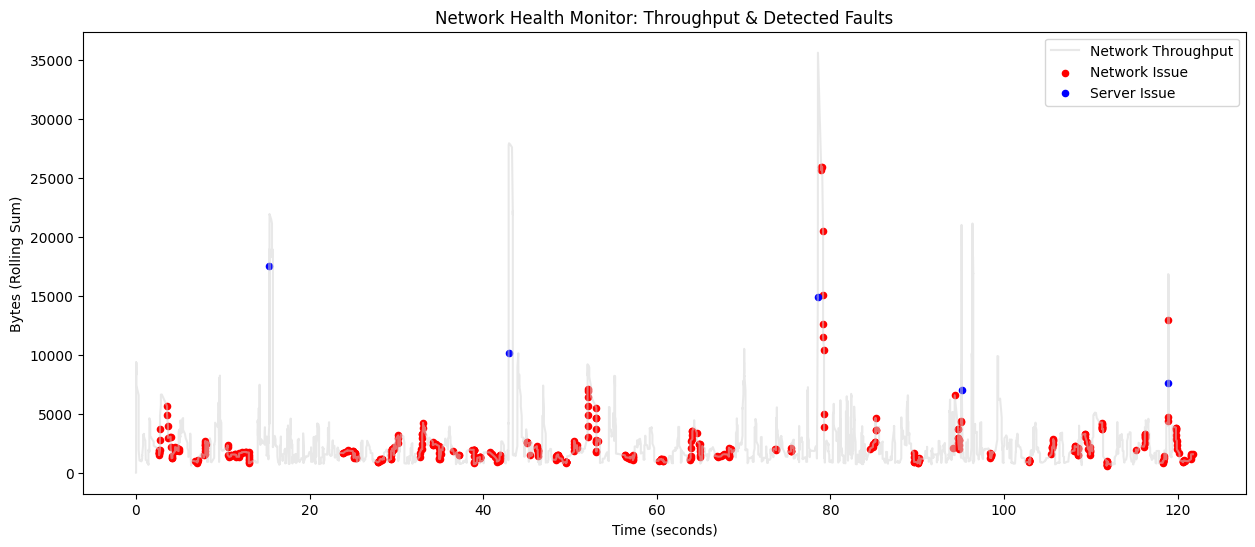

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Load Data with correct encoding
try:
    df = pd.read_csv('youtube traffic.csv', encoding='ISO-8859-1')
except:
    df = pd.read_csv('youtube traffic.csv', encoding='cp1252')

# ---------------------------------------------------------
# 2. ADVANCED FEATURE ENGINEERING
# ---------------------------------------------------------

# A. Base Metrics
df['Time_Delta'] = df['Time'].diff().fillna(0) # Inter-arrival time

# B. Rolling Window Statistics (The "Context" features)
# We look at the last 10 packets to determine the "state" of the network
window_size = 10

# Jitter: Standard deviation of time delta (High jitter = unstable connection)
df['Rolling_Jitter'] = df['Time_Delta'].rolling(window=window_size).std().fillna(0)

# Throughput: Sum of bytes in the window (Sudden drops = congestion)
df['Rolling_Throughput'] = df['Length'].rolling(window=window_size).sum().fillna(0)

# Packet Size Variance: Variation in packet size
df['Rolling_Size_Std'] = df['Length'].rolling(window=window_size).std().fillna(0)

# C. Encode Protocol
le = LabelEncoder()
df['Protocol_Code'] = le.fit_transform(df['Protocol'].astype(str))

# ---------------------------------------------------------
# 3. DEFINE TARGETS (Server vs Network)
# ---------------------------------------------------------
def categorize_traffic(row):
    info = str(row['Info']).lower()
    
    # Network Logic
    if 'retransmission' in info or 'dup ack' in info:
        return 'Network Issue'
    if row['Rolling_Jitter'] > 0.1: # Threshold for high jitter
        return 'Network Issue'
        
    # Server Logic
    if 'rst' in info or 'zerowindow' in info or 'window full' in info:
        return 'Server Issue'
        
    return 'Normal'

df['Target'] = df.apply(categorize_traffic, axis=1)

# ---------------------------------------------------------
# 4. MODEL 1: UNSUPERVISED ANOMALY DETECTION
# ---------------------------------------------------------
# Uses Isolation Forest to find "weird" stuff we didn't define rules for.
feature_cols = ['Time_Delta', 'Length', 'Rolling_Jitter', 'Rolling_Throughput', 'Protocol_Code']
X = df[feature_cols]

# Contamination = estimate of how much bad data is in the set (e.g., 5%)
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Predicted'] = iso_forest.fit_predict(X)
# -1 = Anomaly, 1 = Normal
print(f"Anomalies Detected: {len(df[df['Anomaly_Predicted'] == -1])}")

# ---------------------------------------------------------
# 5. MODEL 2: SUPERVISED CLASSIFIER
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, df['Target'], test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n--- Supervised Model Performance ---")
print(classification_report(y_test, y_pred))

# ---------------------------------------------------------
# 6. ADVANCED VISUALIZATION
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# Plot the "Throughput" as a gray line
plt.plot(df['Time'], df['Rolling_Throughput'], color='lightgray', label='Network Throughput', alpha=0.5)

# Highlight Network Issues in RED
network_issues = df[df['Target'] == 'Network Issue']
plt.scatter(network_issues['Time'], network_issues['Rolling_Throughput'], color='red', s=20, label='Network Issue')

# Highlight Server Issues in BLUE
server_issues = df[df['Target'] == 'Server Issue']
plt.scatter(server_issues['Time'], server_issues['Rolling_Throughput'], color='blue', s=20, label='Server Issue')

plt.title('Network Health Monitor: Throughput & Detected Faults')
plt.xlabel('Time (seconds)')
plt.ylabel('Bytes (Rolling Sum)')
plt.legend()
plt.show()

Loaded 5135 packets.


C:\Users\phani\AppData\Local\Temp\ipykernel_22800\3528969239.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=df, palette='viridis')
C:\Users\phani\AppData\Local\Temp\ipykernel_22800\3528969239.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_sources.values, y=top_sources.index, palette='magma')


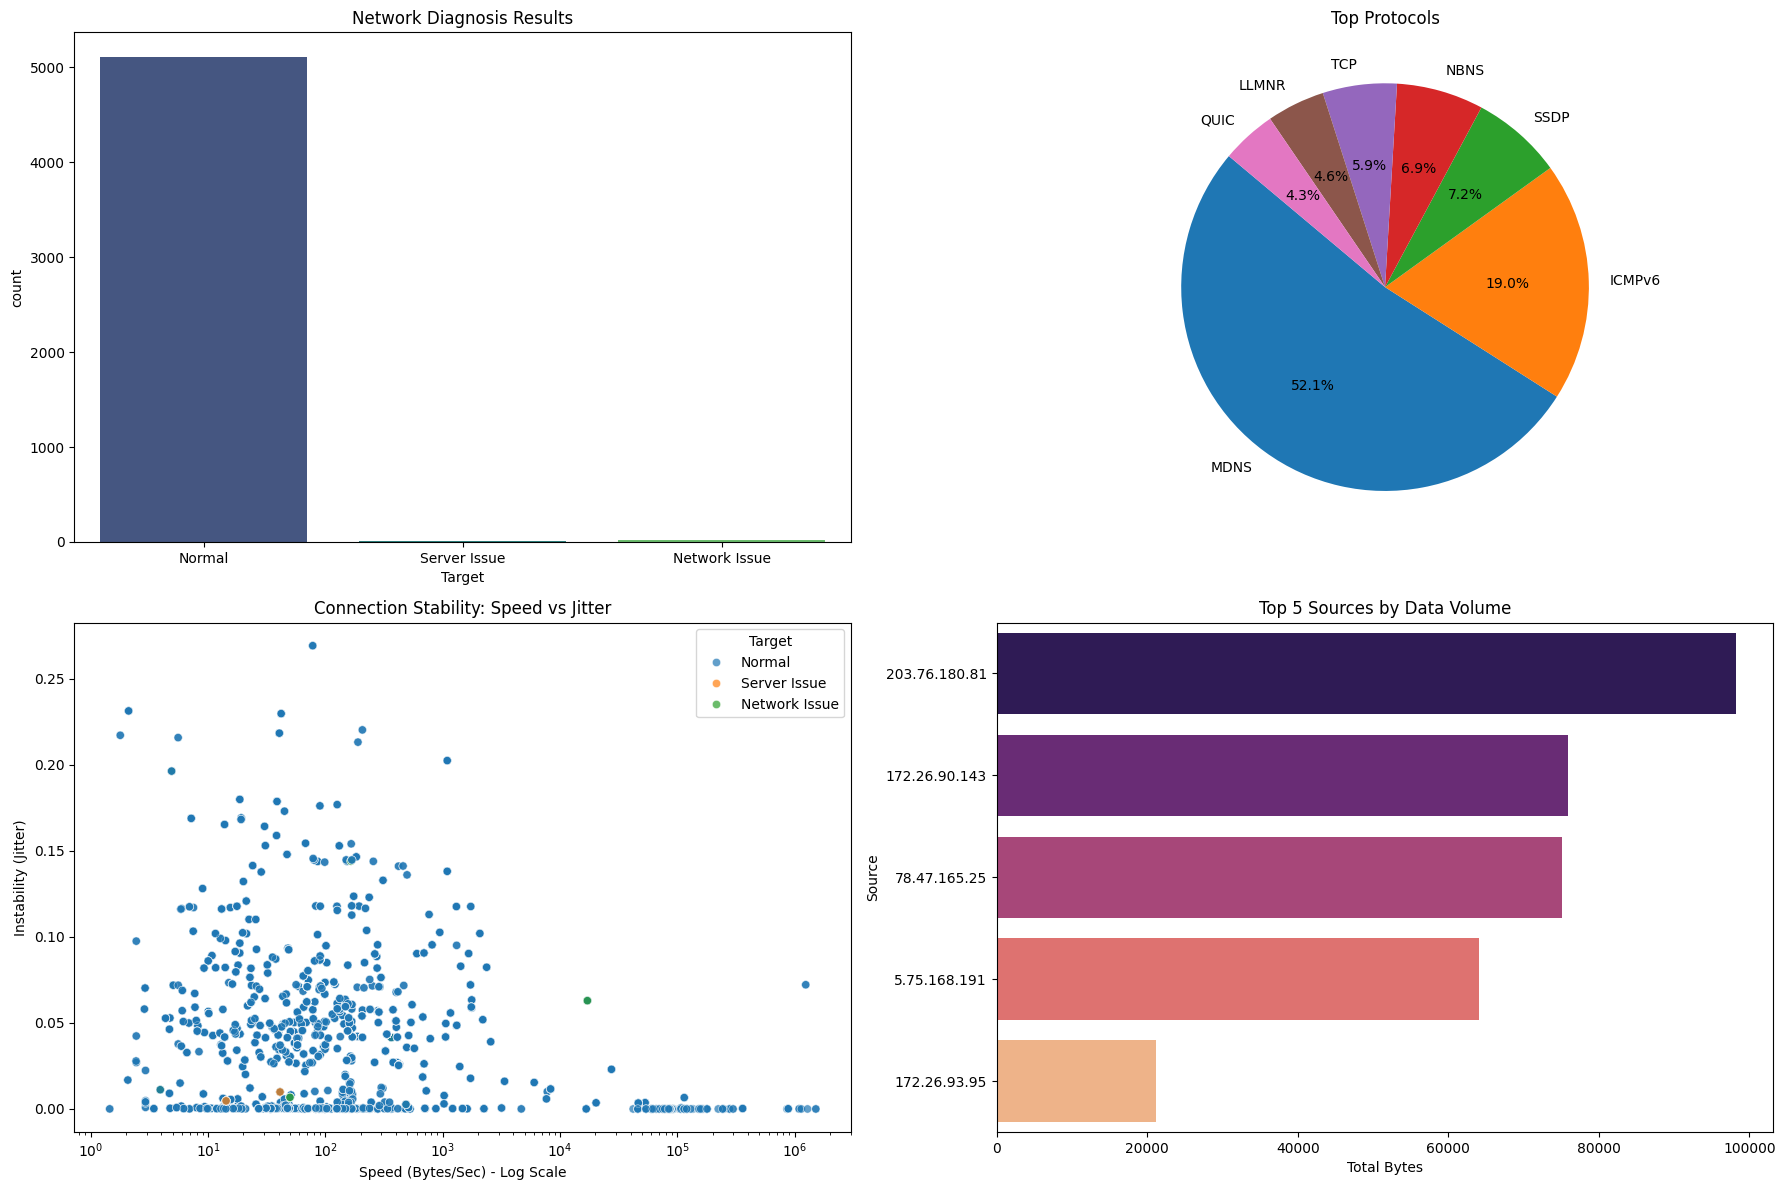


--- Top Factors Influencing Diagnosis ---
Time_Delta       0.264966
Flag_RST         0.194298
Length           0.115253
Flow_Jitter      0.080260
Flow_Rate_Bps    0.077131
dtype: float64


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Load Data
# Handle potential encoding issues automatically
try:
    df = pd.read_csv('youtube traffic.csv', encoding='ISO-8859-1')
except:
    df = pd.read_csv('youtube traffic.csv', encoding='cp1252')

print(f"Loaded {len(df)} packets.")

# ---------------------------------------------------------
# 2. FEATURE ENGINEERING (The "More Features" part)
# ---------------------------------------------------------

# A. Packet-Level Basics
df['Time_Delta'] = df['Time'].diff().fillna(0)

# B. Extract TCP Flags from 'Info' text
# These are critical for detecting Server Resets vs Network Drops
flags = ['SYN', 'ACK', 'FIN', 'RST', 'PSH']
for flag in flags:
    df[f'Flag_{flag}'] = df['Info'].str.contains(flag, case=False).astype(int)

# C. Flow-Level Analysis (The "Deep Analysis" part)
# We group packets into "conversations" (Source <-> Dest)
df['Flow_ID'] = df['Source'] + "-" + df['Destination'] + "-" + df['Protocol']

# Calculate statistics for each unique flow
flow_stats = df.groupby('Flow_ID').agg({
    'Time': ['min', 'max', 'count'],     # Start/End time
    'Length': ['sum', 'mean', 'std'],    # Total bytes, avg size
    'Time_Delta': ['std']                # Jitter (stability)
}).reset_index()

# Rename columns for clarity
flow_stats.columns = ['Flow_ID', 'Flow_Start', 'Flow_End', 'Flow_Packet_Count', 
                      'Flow_Bytes', 'Flow_Mean_Len', 'Flow_Len_Std', 'Flow_Jitter']

# Derived Metrics
flow_stats['Flow_Duration'] = flow_stats['Flow_End'] - flow_stats['Flow_Start']
# Avoid division by zero
flow_stats['Flow_Rate_Bps'] = flow_stats['Flow_Bytes'] / flow_stats['Flow_Duration'].replace(0, 0.001)

# Merge flow stats back into the main dataset
df = df.merge(flow_stats, on='Flow_ID', how='left')
df = df.fillna(0) # Handle NaN values

# D. Directionality (Inbound vs Outbound)
# Heuristic: The most frequent IP starting with private range is likely "My Computer"
local_ip_candidates = df[df['Source'].str.match(r'(192\.168\.|10\.|172\.)')]['Source']
if not local_ip_candidates.empty:
    my_ip = local_ip_candidates.mode()[0]
else:
    my_ip = df['Source'].mode()[0]

df['Direction'] = df.apply(lambda x: 'Outbound' if x['Source'] == my_ip else 'Inbound', axis=1)
# Encode direction as number (0 or 1)
df['Direction_Code'] = (df['Direction'] == 'Outbound').astype(int)

# E. Protocol Encoding
le = LabelEncoder()
df['Protocol_Code'] = le.fit_transform(df['Protocol'].astype(str))

# ---------------------------------------------------------
# 3. LABELING & TRAINING
# ---------------------------------------------------------
def diagnose_packet(row):
    info = str(row['Info']).lower()
    
    # 1. Network Issues (Lag, Packet Loss)
    if 'retransmission' in info or 'dup ack' in info:
        return 'Network Issue'
    if row['Flow_Jitter'] > 0.5: # Unstable connection
        return 'Network Issue'
    if row['Time_Delta'] > 1.0: # Huge lag spike (>1 second)
        return 'Network Issue'

    # 2. Server Issues (Resets, Errors)
    if 'rst' in info or 'zerowindow' in info or 'window full' in info:
        return 'Server Issue'
    if row['Flag_RST'] == 1 and row['Direction'] == 'Inbound': 
        return 'Server Issue' # Server hung up on us
        
    return 'Normal'

df['Target'] = df.apply(diagnose_packet, axis=1)

# Select features for the model
features = ['Time_Delta', 'Length', 'Protocol_Code', 'Flow_Duration', 
            'Flow_Bytes', 'Flow_Packet_Count', 'Flow_Jitter', 'Flow_Rate_Bps',
            'Flag_SYN', 'Flag_ACK', 'Flag_FIN', 'Flag_RST', 'Direction_Code']

X = df[features]
y = df['Target']

# Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ---------------------------------------------------------
# 4. VISUALIZATION DASHBOARD
# ---------------------------------------------------------
plt.figure(figsize=(18, 12))

# Chart 1: Target Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='Target', data=df, palette='viridis')
plt.title('Network Diagnosis Results')

# Chart 2: Protocol Usage
plt.subplot(2, 2, 2)
top_protocols = df['Protocol'].value_counts().head(7)
plt.pie(top_protocols, labels=top_protocols.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Protocols')

# Chart 3: Performance Analysis (Jitter vs Speed)
plt.subplot(2, 2, 3)
sns.scatterplot(x='Flow_Rate_Bps', y='Flow_Jitter', hue='Target', data=df, alpha=0.7)
plt.xscale('log') # Log scale because speeds vary wildly
plt.title('Connection Stability: Speed vs Jitter')
plt.xlabel('Speed (Bytes/Sec) - Log Scale')
plt.ylabel('Instability (Jitter)')

# Chart 4: Top Talkers (Who is using the bandwidth?)
plt.subplot(2, 2, 4)
top_sources = df.groupby('Source')['Length'].sum().sort_values(ascending=False).head(5)
sns.barplot(x=top_sources.values, y=top_sources.index, palette='magma')
plt.title('Top 5 Sources by Data Volume')
plt.xlabel('Total Bytes')

plt.tight_layout()
plt.show()

# Print Feature Importance (What matters most?)
importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
print("\n--- Top Factors Influencing Diagnosis ---")
print(importances.head(5))